In [1]:
#Extract spectogram_images.zip
import zipfile
with zipfile.ZipFile("/content/spectogram_images.zip","r") as zip_ref:
    zip_ref.extractall("./")

In [ ]:
import tensorflow as tf

# Allow GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')

# Check if GPUs are available
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

    print("GPU memory growth enabled.")
else:
    print("No GPUs found.")


GPU memory growth enabled.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers

# GPU configuration in TensorFlow 2.x
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Additional imports
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

%matplotlib inline


In [3]:
IMG_DIR = '/content/spectogram_images/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 10
NUM_EPOCHS = 10
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [4]:
label_dict = {'blues':0,
              'classical':1,
              'country':2,
              'disco':3,
              'hiphop':4,
              'jazz':5,
              'metal':6,
              'pop':7,
              'reggae':8,
              'rock':9
             }

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Assuming NUM_CLASSES is already defined
one_hot = OneHotEncoder(categories=[list(range(NUM_CLASSES))])

In [6]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Generate label dictionary from folder names
genres = sorted([folder for folder in os.listdir(IMG_DIR) if os.path.isdir(os.path.join(IMG_DIR, folder))])
label_dict = {genre: idx for idx, genre in enumerate(genres)}

#print(label_dict)

# Collect all audio files and corresponding labels
all_files = []
label_array = []

for genre, label in label_dict.items():
    genre_folder = os.path.join(IMG_DIR, genre)
    image_files = [os.path.join(genre_folder, file) for file in os.listdir(genre_folder)]
    all_files.extend(image_files)
    label_array.extend([label] * len(image_files))

# Compute class weights
cl_weight = compute_class_weight(class_weight='balanced', classes=np.unique(label_array), y=label_array)

from tensorflow.keras.utils import to_categorical

# Example: Convert integer labels to one-hot encoded labels
labels_one_hot = to_categorical(label_array, num_classes=10)  # Assuming 10 classes


# Train-validation-test split
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, labels_one_hot, random_state=10, test_size=0.1
)

val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, random_state=10, test_size=0.5
)

# Print dataset statistics for verification
print(f"Total files: {len(all_files)}")
print(f"Train files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")


Total files: 999
Train files: 899, Validation files: 50, Test files: 50


In [7]:
from tensorflow.keras.applications import VGG16

# Define input shape
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Load pre-trained VGG16 model without the top classification layer
conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)  # 3 channels for RGB images
)

# Display model summary to verify
conv_base.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # Flatten output and send it to MLP

# 1-layer MLP with Dropout, BN
model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_output (Dense)                 │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 27,565,386 (105.15 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Set the convolution base to be not trainable
conv_base.trainable = False
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_output (Dense)                 │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 12,850,698 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(IMG_DIR + file_)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        img_array.append(np.array(im))

        vals = file_[:-4].split('_')
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])

    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB

    return img_array, np.array(label_array), np.array(idx_array)

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def batch_generator(file_paths, labels, batch_size):
    while True:  # Loop forever so the generator never terminates
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            # Load and preprocess images in the batch
            images = []
            for path in batch_paths:
                img = load_img(path, target_size=(224, 224))  # Resize image if needed
                img = img_to_array(img) / 255.0  # Convert to array and normalize
                images.append(img)

            # Convert the list of images to a NumPy array
            images = np.array(images)

            # If you want to use sample weights, you can calculate and yield them here
            yield images, np.array(batch_labels)

In [12]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(learning_rate=1e-5)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

filepath = "/content/saved_models/transfer_learning_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.keras"
checkpoint = callbacks.ModelCheckpoint(
    filepath,
    monitor='val_categorical_accuracy',
    verbose=0,
    save_best_only=False
)
callbacks_list = [checkpoint]


In [13]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

BATCH_SIZE = 32
history = model.fit(
    x=batch_generator(train_files, train_labels, BATCH_SIZE),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=batch_generator(val_files, val_labels, BATCH_SIZE),
    validation_steps=VAL_STEPS,
    callbacks=callbacks_list
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - categorical_accuracy: 0.1385 - loss: 3.4671 - val_categorical_accuracy: 0.2812 - val_loss: 2.9869
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - categorical_accuracy: 0.2436 - loss: 3.0735 - val_categorical_accuracy: 0.3889 - val_loss: 2.8993
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - categorical_accuracy: 0.3569 - loss: 2.8252 - val_categorical_accuracy: 0.5312 - val_loss: 2.5840
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - categorical_accuracy: 0.4290 - loss: 2.6636 - val_categorical_accuracy: 0.3889 - val_loss: 2.5872
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - categorical_accuracy: 0.4824 - loss: 2.5018 - val_categorical_accuracy: 0.6250 - val_loss: 2.3332
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - categorical_accuracy: 0.4905 - loss: 2.4076 - val_categorical_accuracy: 0.5000 - val_loss: 2.3596
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - categorical_accuracy: 0.5361 - loss: 2.30

In [14]:
# Save scores on train and validation sets
with open('/content/transfer_learning_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [15]:
with open('/content/transfer_learning_vgg16_history.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,11))

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])


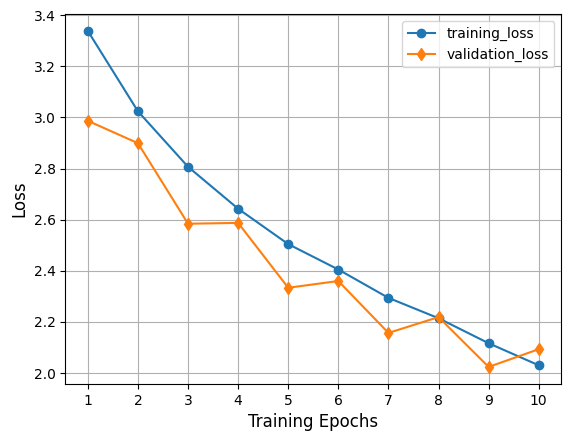

In [16]:
plt.xticks(range(1,11))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

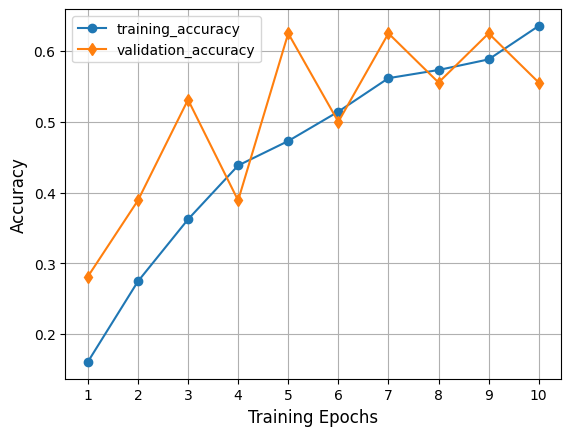

In [17]:
plt.xticks(range(1,11))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

In [77]:
model = models.load_model(filepath='/content/saved_models/transfer_learning_epoch_10_0.5556.keras') # 02 is epoch 3

In [78]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict(x = batch_generator(test_files, test_labels,BATCH_SIZE),
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [79]:
#!pip install scipy
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
#from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

In [67]:
print(f"Shape of y_true: {test_labels[:len(pred)].shape}")
print(f"Shape of y_pred: {pred.shape}")
print(f"Example y_true: {test_labels[0]}")
print(f"Example y_pred: {pred[0]}")


Shape of y_true: (32, 10)
Shape of y_pred: (32,)
Example y_true: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Example y_pred: 5


In [80]:
y_true = np.argmax(test_labels[:len(pred)], axis=1)


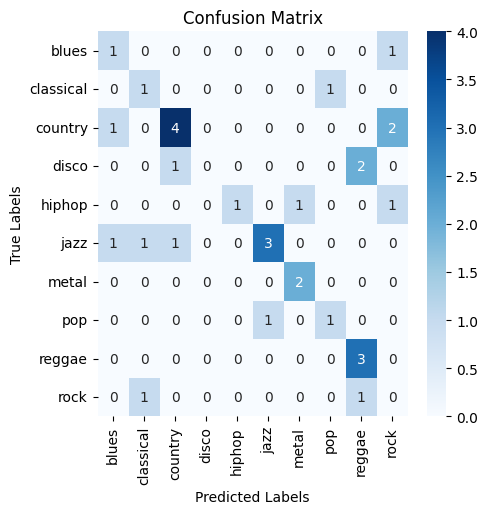

In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure `y_true` contains the true class labels
y_true = np.argmax(test_labels[:len(pred)], axis=1)  # Convert one-hot true labels to class labels

# Use `pred` directly as it already contains predicted class labels
y_pred = pred

# Compute confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [82]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true, y_pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true, y_pred, average='macro')))

Test Set Accuracy =  0.50
Test Set F-score =  0.45
